# Climate Extremes Event Characteristics Using Run Theory

This notebook demonstrates how to analyze climate extreme events using run theory (Yevjevich, 1967) with **real TerraClimate data from Bali, Indonesia (1958-2024)**. We'll explore **three modes** of analysis:

1. **Event-Based Analysis** - Identify and characterize complete extreme events
2. **Time-Series Monitoring** - Track evolution month-by-month
3. **Period Statistics** - Gridded statistics for decision-making

**Learning Objectives:**
1. Understand run theory and extreme event identification
2. Calculate event characteristics (duration, magnitude, intensity, peak)
3. Use three analysis modes for different purposes
4. Understand dual magnitude (cumulative vs instantaneous)
5. Answer decision-maker questions with spatial statistics
6. Visualize extreme events and evolution

## Run Theory Framework

Run theory provides a systematic approach to analyzing climate extremes:

![Run Theory](../docs/images/runtheory.png)

**Key Concepts:**
- **Events** are identified when SPI/SPEI crosses a threshold
- **Duration (D)**: How long the event lasts
- **Magnitude (M)**: Total accumulated deficit/surplus
- **Intensity (I)**: Average severity = M/D
- **Inter-arrival Time (T)**: Time between events

**This notebook works for BOTH extremes:**
- 🌵 **Dry Events**: Use negative thresholds (e.g., -1.2)
- 🌊 **Wet Events**: Use positive thresholds (e.g., +1.2)

The analysis code is identical—only the threshold sign changes!

For detailed explanation, see [docs/user-guide/runtheory.md](../docs/user-guide/runtheory.md)

## 1. Setup and Imports

In [1]:
# Add src directory to Python path
import sys
sys.path.insert(0, '../src')

# Core libraries
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Import event analysis functions
from runtheory import (
    identify_events,
    calculate_timeseries,
    calculate_period_statistics,
    calculate_annual_statistics,
    compare_periods,
    summarize_events
)

# Import visualization functions
from visualization import (
    plot_index,
    plot_events,
    plot_event_timeline,
    plot_spatial_stats,
    generate_location_filename
)

# Plotting settings
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Create output directories
os.makedirs('../output/csv', exist_ok=True)
os.makedirs('../output/plots/single', exist_ok=True)
os.makedirs('../output/plots/spatial', exist_ok=True)

print("✓ All imports successful!")
print("✓ Output directories created")

✓ All imports successful!
✓ Output directories created


## 2. Load SPI-12 Data

We'll use SPI-12 calculated from real Bali precipitation data (from notebook 01).

In [2]:
# Load SPI-12 from previous notebook
spi_file = '../output/netcdf/spi_12_bali.nc'

if os.path.exists(spi_file):
    ds = xr.open_dataset(spi_file)
    spi = ds['spi_gamma_12_month']
    print("✓ SPI-12 loaded successfully!")
else:
    print("❌ SPI file not found. Please run notebook 01_calculate_spi.ipynb first.")
    print(f"   Expected location: {spi_file}")
    raise FileNotFoundError("Please calculate SPI first using notebook 01")

print(f"\nDataset Information:")
print(f"  Shape: {spi.shape}")
print(f"  Dimensions: {spi.dims}")
print(f"  Time range: {spi.time[0].values} to {spi.time[-1].values}")
print(f"  Spatial extent: {len(spi.lat)} x {len(spi.lon)} grid (Bali, Indonesia)")
print(f"  Lat range: {float(spi.lat.min()):.2f}° to {float(spi.lat.max()):.2f}°")
print(f"  Lon range: {float(spi.lon.min()):.2f}° to {float(spi.lon.max()):.2f}°")

✓ SPI-12 loaded successfully!

Dataset Information:
  Shape: (804, 24, 35)
  Dimensions: ('time', 'lat', 'lon')
  Time range: 1958-01-01T00:00:00.000000000 to 2024-12-01T00:00:00.000000000
  Spatial extent: 24 x 35 grid (Bali, Indonesia)
  Lat range: -8.94° to -7.98°
  Lon range: 114.35° to 115.77°


## 3. Select Sample Location

For event-based and time-series analysis, we'll extract a single location in Bali.

Selected location: -8.48°, 115.06° (Central Bali)
SPI time series length: 804 months (67.0 years)
Mean SPI: -0.049
Std SPI: 1.006


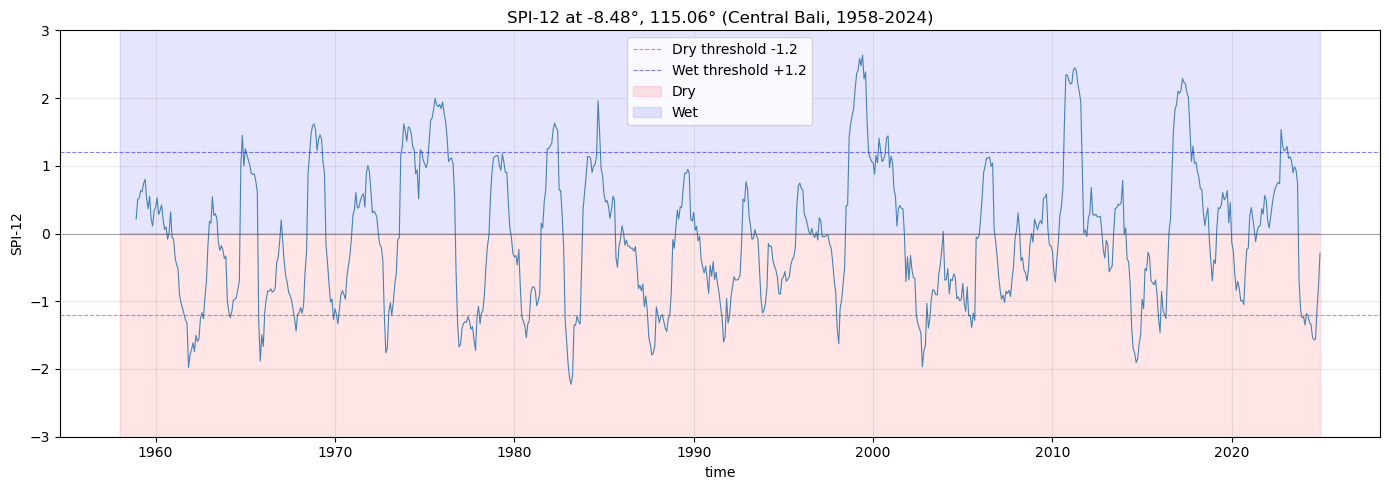

In [3]:
# Select center of Bali
lat_idx = len(spi.lat) // 2
lon_idx = len(spi.lon) // 2

# Extract location
spi_loc = spi.isel(lat=lat_idx, lon=lon_idx)
lat_val = float(spi.lat.values[lat_idx])
lon_val = float(spi.lon.values[lon_idx])

print(f"Selected location: {lat_val:.2f}°, {lon_val:.2f}° (Central Bali)")
print(f"SPI time series length: {len(spi_loc)} months ({len(spi_loc)/12:.1f} years)")
print(f"Mean SPI: {float(spi_loc.mean()):.3f}")
print(f"Std SPI: {float(spi_loc.std()):.3f}")

# Quick visualization
fig, ax = plt.subplots(figsize=(14, 5))
spi_loc.plot(ax=ax, linewidth=0.8, color='steelblue')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.8, alpha=0.3)
ax.axhline(y=-1.2, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='Dry threshold -1.2')
ax.axhline(y=1.2, color='blue', linestyle='--', linewidth=0.8, alpha=0.5, label='Wet threshold +1.2')
ax.fill_between(spi_loc.time, -5, 0, alpha=0.1, color='red', label='Dry')
ax.fill_between(spi_loc.time, 0, 5, alpha=0.1, color='blue', label='Wet')
ax.set_ylim(-3, 3)
ax.set_title(f'SPI-12 at {lat_val:.2f}°, {lon_val:.2f}° (Central Bali, 1958-2024)')
ax.set_ylabel('SPI-12')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Mode 1: Event-Based Analysis (Dry Events)

Identify complete dry events using run theory. Each event is characterized by:
- **Duration** (D): Length in months
- **Magnitude** (M): Cumulative deficit
- **Intensity** (I): M / D (average severity)
- **Peak** (P): Minimum SPI value
- **Inter-arrival**: Time between events

In [4]:
# Identify dry events (drought)
threshold_dry = -1.2  # Moderate dry threshold
min_duration = 3  # Minimum 3 months to be considered an event

print(f"Identifying dry events with:")
print(f"  Threshold: {threshold_dry}")
print(f"  Minimum duration: {min_duration} months")
print()

events_dry = identify_events(spi_loc, threshold=threshold_dry, min_duration=min_duration)

print(f"✓ Found {len(events_dry)} dry events")
print()
print("Dry Event Summary:")
print(events_dry.head(10))

Identifying dry events with:
  Threshold: -1.2
  Minimum duration: 3 months

✓ Found 14 dry events

Dry Event Summary:
   event_id  start_idx  end_idx start_date   end_date  duration  magnitude  \
0         1         44       54 1961-09-01 1962-07-01        11   4.158427   
1         2         93       96 1965-10-01 1966-01-01         4   1.563216   
2         3        177      179 1972-10-01 1972-12-01         3   1.060239   
3         4        226      239 1976-11-01 1977-12-01        14   3.015793   
4         5        269      274 1980-06-01 1980-11-01         6   0.842434   
5         6        298      308 1982-11-01 1983-09-01        11   4.622384   
6         7        354      358 1987-07-01 1987-11-01         5   2.381182   
7         8        364      368 1988-05-01 1988-09-01         5   0.601314   
8         9        403      405 1991-08-01 1991-10-01         3   0.781448   
9        10        533      539 2002-06-01 2002-12-01         7   2.373328   

   intensity      peak

### Dry Event Statistics

In [5]:
# Summarize dry events
summary_dry = summarize_events(events_dry)

print("Dry Event Statistics:")
print("=" * 50)
print(f"Total events: {summary_dry['num_events']}")
print(f"Mean duration: {summary_dry['mean_duration']:.1f} months")
print(f"Max duration: {summary_dry['max_duration']} months")
print(f"Mean magnitude: {summary_dry['mean_magnitude']:.2f}")
print(f"Max magnitude: {summary_dry['max_magnitude']:.2f}")
print(f"Most severe peak: {summary_dry['most_severe_peak']:.2f}")
print(f"Mean inter-arrival: {summary_dry['mean_interarrival']:.1f} months")

# Distribution statistics
print("\nEvent Characteristics Distribution:")
print(events_dry[['duration', 'magnitude', 'intensity', 'peak']].describe())

Dry Event Statistics:
Total events: 14.0
Mean duration: 6.3 months
Max duration: 14.0 months
Mean magnitude: 1.89
Max magnitude: 4.62
Most severe peak: -2.22
Mean inter-arrival: 57.8 months

Event Characteristics Distribution:
        duration  magnitude  intensity       peak
count  14.000000  14.000000  14.000000  14.000000
mean    6.285714   1.890887   0.280944  -1.724541
std     3.473605   1.443315   0.142946   0.253914
min     3.000000   0.212775   0.070925  -2.224833
25%     3.250000   0.796694   0.159158  -1.900197
50%     5.500000   1.443898   0.299765  -1.743995
75%     7.000000   2.857140   0.387613  -1.547340
max    14.000000   4.622384   0.476236  -1.351456


### Visualize Dry Events

✓ Saved plot: dry_events_lat-8.48_lon115.06.png


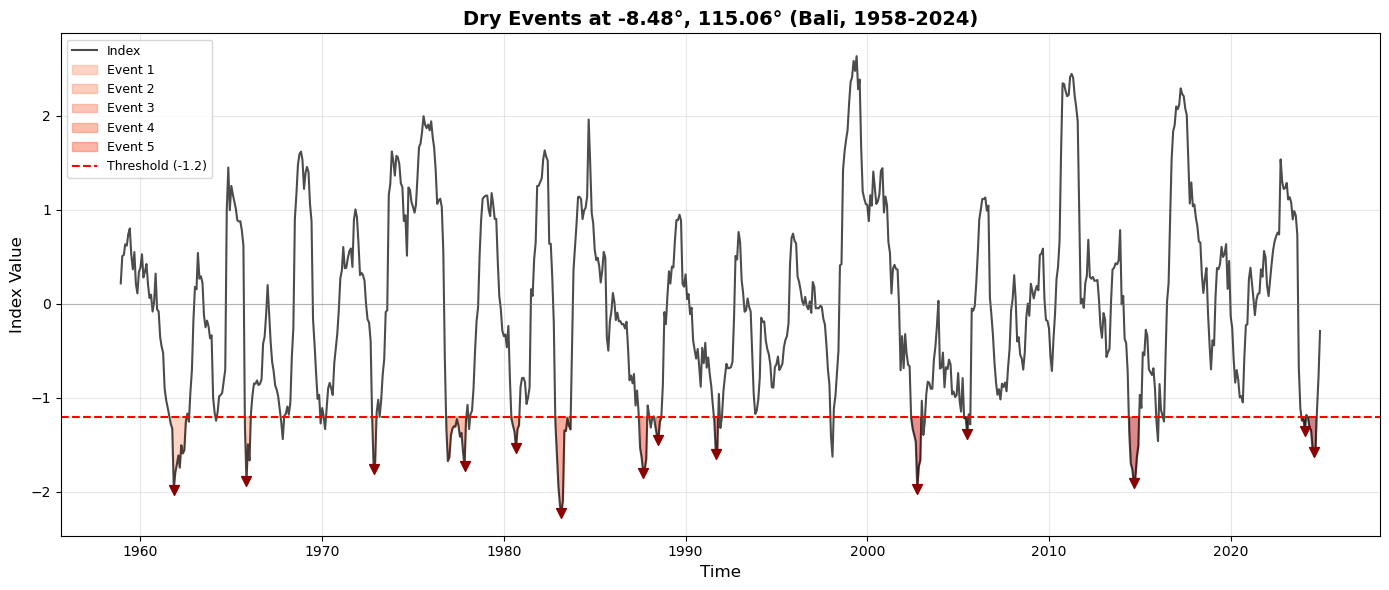

In [6]:
# Plot dry events timeline
fig = plot_events(spi_loc, events_dry, threshold=threshold_dry,
                  title=f'Dry Events at {lat_val:.2f}°, {lon_val:.2f}° (Bali, 1958-2024)')

# Save
filename = f'dry_events_lat{lat_val:.2f}_lon{lon_val:.2f}.png'
plt.savefig(f'../output/plots/single/{filename}', dpi=300, bbox_inches='tight')
print(f"✓ Saved plot: {filename}")

plt.show()

## 5. Wet Events Analysis (Same Functions!)

Now analyze wet events using positive threshold - the exact same functions work!

In [7]:
# Identify wet events (flooding/excess precipitation)
threshold_wet = 1.2  # Moderate wet threshold (positive!)

print(f"Identifying wet events with:")
print(f"  Threshold: {threshold_wet}")
print(f"  Minimum duration: {min_duration} months")
print()

events_wet = identify_events(spi_loc, threshold=threshold_wet, min_duration=min_duration)

print(f"✓ Found {len(events_wet)} wet events")
print()
print("Wet Event Summary:")
print(events_wet.head(10))

Identifying wet events with:
  Threshold: 1.2
  Minimum duration: 3 months

✓ Found 8 wet events

Wet Event Summary:
   event_id  start_idx  end_idx start_date   end_date  duration  magnitude  \
0         1        128      135 1968-09-01 1969-04-01         8   2.090787   
1         2        189      197 1973-10-01 1974-06-01         9   2.115472   
2         3        207      219 1975-04-01 1976-04-01        13   7.253482   
3         4        286      293 1981-11-01 1982-06-01         8   1.791788   
4         5        488      500 1998-09-01 1999-09-01        13  11.949759   
5         6        632      643 2010-09-01 2011-08-01        12  12.106092   
6         7        705      716 2016-10-01 2017-09-01        12   9.510721   
7         8        777      781 2022-10-01 2023-02-01         5   0.573034   

   intensity      peak  peak_idx  peak_date  interarrival  
0   0.261348  1.618878       130 1968-11-01          61.0  
1   0.235052  1.619835       190 1973-11-01          18.0  


### Wet Event Statistics

In [8]:
# Summarize wet events
summary_wet = summarize_events(events_wet)

print("Wet Event Statistics:")
print("=" * 50)
print(f"Total events: {summary_wet['num_events']}")
print(f"Mean duration: {summary_wet['mean_duration']:.1f} months")
print(f"Max duration: {summary_wet['max_duration']} months")
print(f"Mean magnitude: {summary_wet['mean_magnitude']:.2f}")
print(f"Max magnitude: {summary_wet['max_magnitude']:.2f}")
print(f"Most extreme peak: {summary_wet['most_severe_peak']:.2f}")
print(f"Mean inter-arrival: {summary_wet['mean_interarrival']:.1f} months")

# Compare dry vs wet
print("\n" + "=" * 50)
print("Comparison: Dry vs Wet Events")
print("=" * 50)
print(f"Dry events: {summary_dry['num_events']}  |  Wet events: {summary_wet['num_events']}")
print(f"Dry avg duration: {summary_dry['mean_duration']:.1f} months  |  Wet avg duration: {summary_wet['mean_duration']:.1f} months")
print(f"Dry avg magnitude: {summary_dry['mean_magnitude']:.2f}  |  Wet avg magnitude: {summary_wet['mean_magnitude']:.2f}")

Wet Event Statistics:
Total events: 8.0
Mean duration: 10.0 months
Max duration: 13.0 months
Mean magnitude: 5.92
Max magnitude: 12.11
Most extreme peak: 1.54
Mean inter-arrival: 92.7 months

Comparison: Dry vs Wet Events
Dry events: 14.0  |  Wet events: 8.0
Dry avg duration: 6.3 months  |  Wet avg duration: 10.0 months
Dry avg magnitude: 1.89  |  Wet avg magnitude: 5.92


### Visualize Wet Events

✓ Saved plot: wet_events_lat-8.48_lon115.06.png


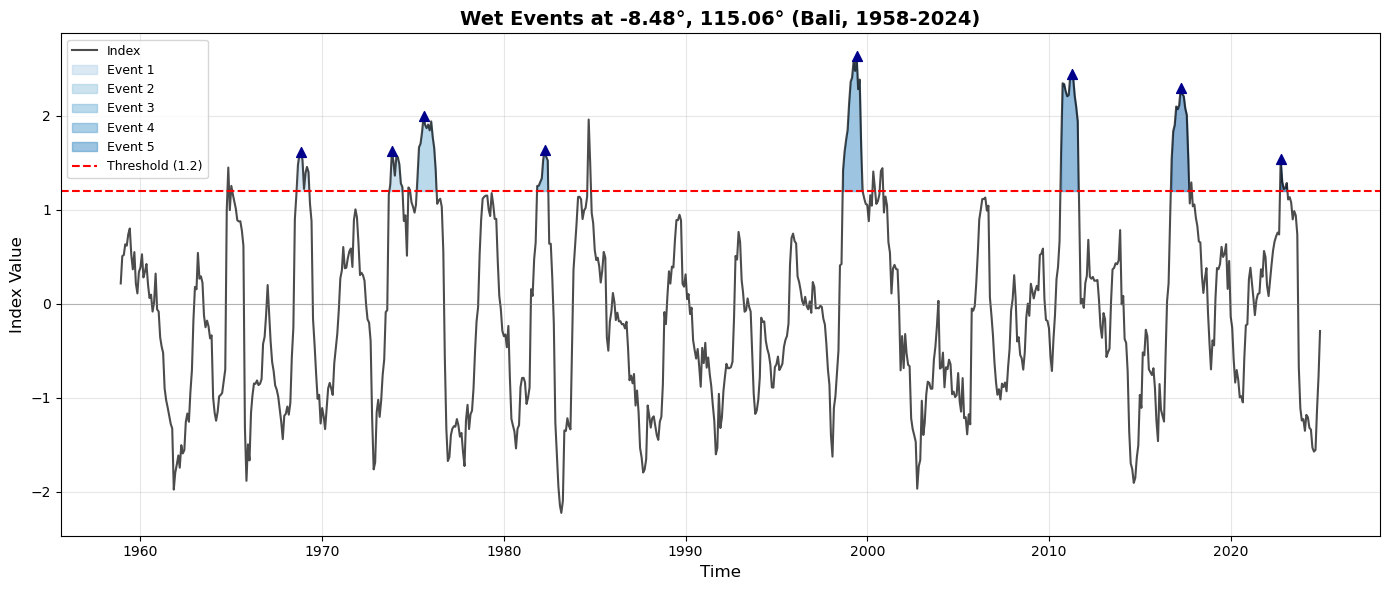

In [9]:
# Plot wet events timeline
fig = plot_events(spi_loc, events_wet, threshold=threshold_wet,
                  title=f'Wet Events at {lat_val:.2f}°, {lon_val:.2f}° (Bali, 1958-2024)')

# Save
filename = f'wet_events_lat{lat_val:.2f}_lon{lon_val:.2f}.png'
plt.savefig(f'../output/plots/single/{filename}', dpi=300, bbox_inches='tight')
print(f"✓ Saved plot: {filename}")

plt.show()

### Save Events to CSV

In [10]:
# Save dry events
csv_filename = f'dry_events_lat{lat_val:.2f}_lon{lon_val:.2f}.csv'
events_dry.to_csv(f'../output/csv/{csv_filename}', index=False)
print(f"✓ Dry events saved to: ../output/csv/{csv_filename}")

# Save wet events
csv_filename = f'wet_events_lat{lat_val:.2f}_lon{lon_val:.2f}.csv'
events_wet.to_csv(f'../output/csv/{csv_filename}', index=False)
print(f"✓ Wet events saved to: ../output/csv/{csv_filename}")

✓ Dry events saved to: ../output/csv/dry_events_lat-8.48_lon115.06.csv
✓ Wet events saved to: ../output/csv/wet_events_lat-8.48_lon115.06.csv


## 6. Mode 2: Time-Series Monitoring (Dry Events)

Calculate month-by-month characteristics for real-time monitoring. This provides varying intensity tracking, useful for operational systems.

In [11]:
# Calculate dry event time series
print("Calculating dry event time series...")
ts_dry = calculate_timeseries(spi_loc, threshold=threshold_dry)

print(f"✓ Time series calculated")
print(f"  Length: {len(ts_dry)} months")
print(f"  Columns: {list(ts_dry.columns)}")
print()
print("Sample data:")
print(ts_dry.head(10))

Calculating dry event time series...
✓ Time series calculated
  Length: 804 months
  Columns: ['index_value', 'is_event', 'event_id', 'duration', 'magnitude_cumulative', 'magnitude_instantaneous', 'intensity', 'peak_so_far', 'deviation']

Sample data:
            index_value  is_event  event_id  duration  magnitude_cumulative  \
time                                                                          
1958-01-01          NaN     False         0         0                   0.0   
1958-02-01          NaN     False         0         0                   0.0   
1958-03-01          NaN     False         0         0                   0.0   
1958-04-01          NaN     False         0         0                   0.0   
1958-05-01          NaN     False         0         0                   0.0   
1958-06-01          NaN     False         0         0                   0.0   
1958-07-01          NaN     False         0         0                   0.0   
1958-08-01          NaN     False    

### Current Status Check

In [12]:
# Check current status (last month in data)
current = ts_dry.iloc[-1]

print("Current Status (Latest Data):")
print("=" * 50)
print(f"Date: {ts_dry.index[-1]}")  # Access time from index, not as column
print(f"SPI-12: {current['index_value']:.2f}")

if current['is_event']:
    print(f"\n🔴 DRY EVENT IN PROGRESS")
    print(f"  Event ID: {current['event_id']}")
    print(f"  Duration: {current['duration']} months")
    print(f"  Cumulative magnitude: {current['magnitude_cumulative']:.2f}")
    print(f"  Current severity: {current['magnitude_instantaneous']:.2f}")
    print(f"  Intensity: {current['intensity']:.2f}")
else:
    print(f"\n🟢 NO DRY EVENT")
    print(f"  Normal conditions")

Current Status (Latest Data):
Date: 2024-12-01 00:00:00
SPI-12: -0.29

🟢 NO DRY EVENT
  Normal conditions


### Event Evolution Analysis

Check if recent event is worsening or easing based on instantaneous magnitude trend.

In [13]:
# Analyze recent trend (last 3 months)
recent = ts_dry.tail(3)

if recent['is_event'].any():
    recent_inst = recent[recent['is_event']]['magnitude_instantaneous']
    
    if len(recent_inst) >= 2:
        if recent_inst.is_monotonic_decreasing:
            print("📉 EVENT EASING - Instantaneous severity decreasing")
        elif recent_inst.is_monotonic_increasing:
            print("📈 EVENT WORSENING - Instantaneous severity increasing")
        else:
            print("➡️ EVENT FLUCTUATING - Variable severity")
        
        print(f"\nRecent instantaneous magnitude:")
        for idx, row in recent[recent['is_event']].iterrows():
            print(f"  {idx}: {row['magnitude_instantaneous']:.2f}")  # idx is the time from index
else:
    print("No active dry event in recent months")

No active dry event in recent months


### Visualize Event Timeline (5-Panel Plot)

This shows:
1. Index value (SPI-12)
2. Duration
3. Magnitude - Cumulative (blue, always increasing)
4. Magnitude - Instantaneous (red, NDVI-like pattern)
5. Intensity

✓ Saved timeline plot: dry_timeline_lat-8.48_lon115.06.png


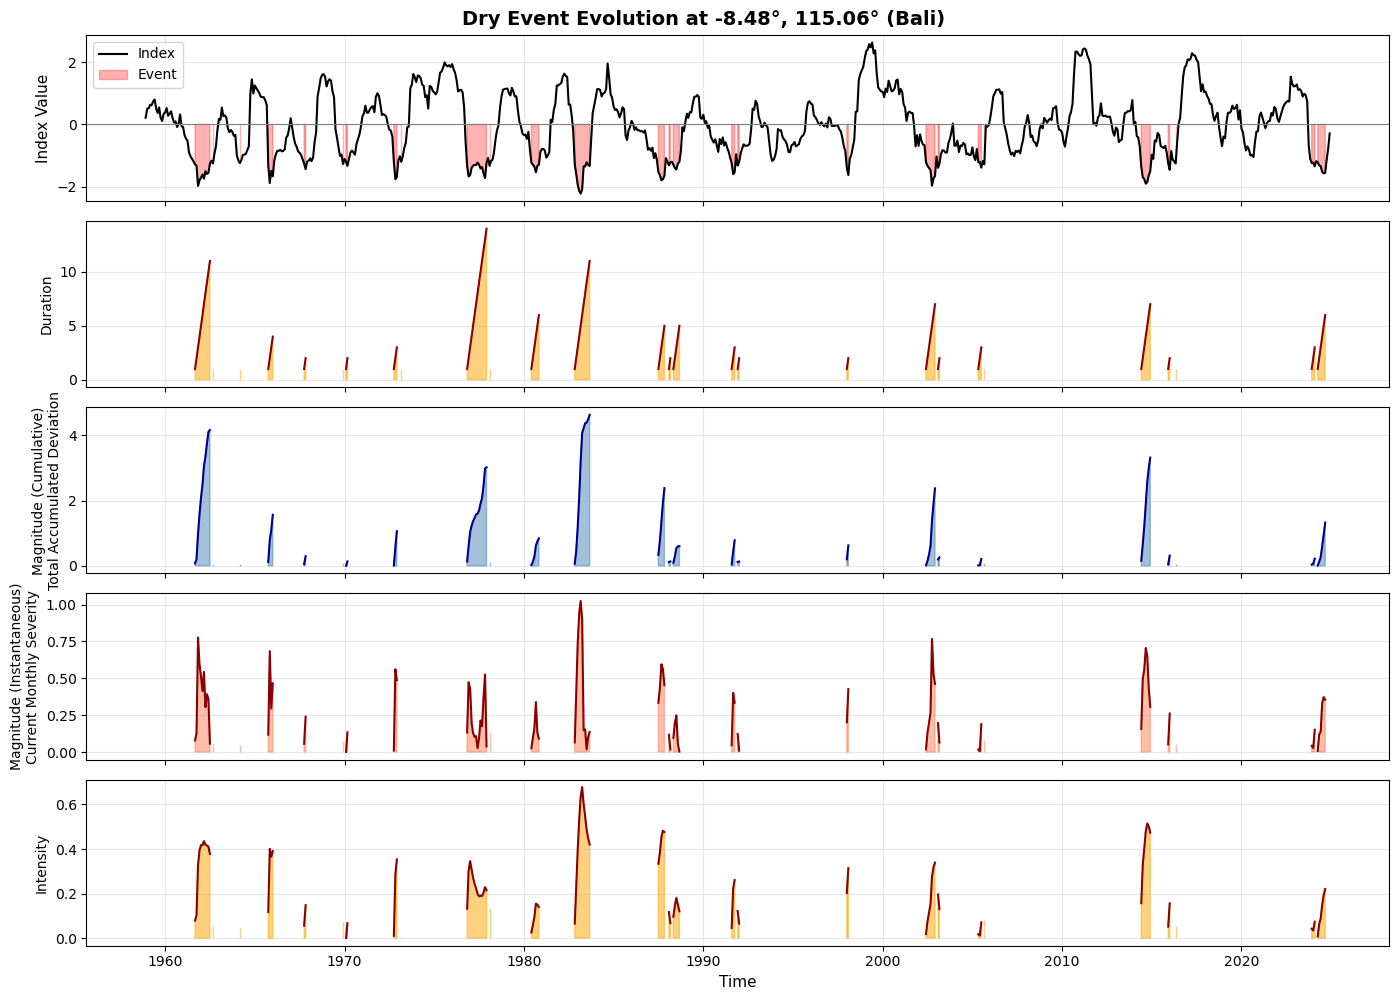

In [14]:
# Plot 5-panel event evolution
fig = plot_event_timeline(ts_dry)

# Replace the default title with custom one
# Remove the default title from first subplot and add suptitle
axes = fig.get_axes()
axes[0].set_title('')  # Remove default title

# Add custom suptitle with proper spacing
fig.suptitle(f'Dry Event Evolution at {lat_val:.2f}°, {lon_val:.2f}° (Bali)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.subplots_adjust(top=0.97)  # Adjust to prevent overlap

# Save
filename = f'dry_timeline_lat{lat_val:.2f}_lon{lon_val:.2f}.png'
plt.savefig(f'../output/plots/single/{filename}', dpi=300, bbox_inches='tight')
print(f"✓ Saved timeline plot: {filename}")

plt.show()

### Magnitude Comparison: Cumulative vs Instantaneous

**Key Differences:**
- **Cumulative (blue)**: Total deficit, monotonically increases during event, like debt accumulation
- **Instantaneous (red)**: Current severity, varies with SPI pattern, like NDVI crop phenology

See [docs/user-guide/magnitude.md](../docs/user-guide/magnitude.md) for detailed explanation.

✓ Saved magnitude comparison: magnitude_comparison_lat-8.48_lon115.06.png


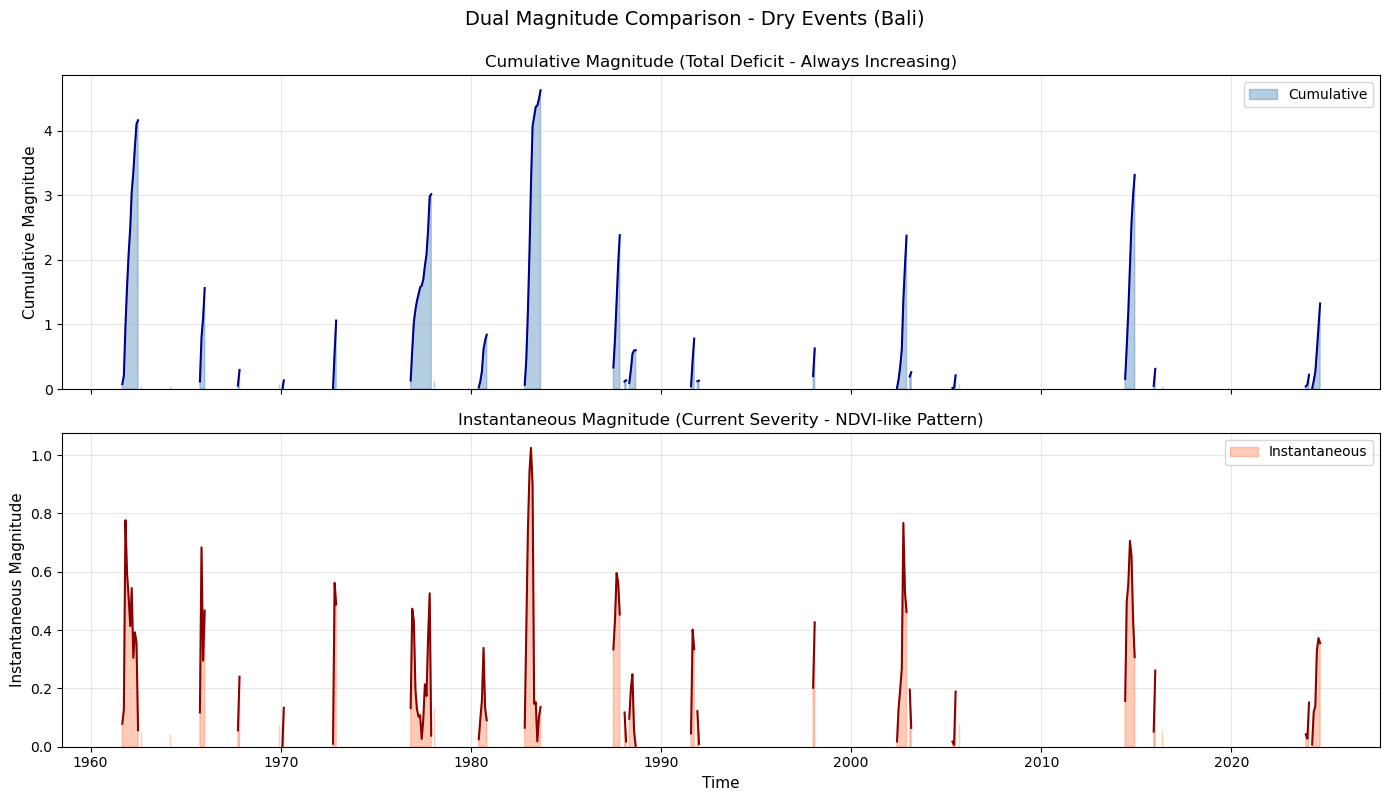

In [15]:
# Compare both magnitude types
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Get event mask
event_mask = ts_dry['is_event']

# Cumulative magnitude (blue) - only during events
cumulative_event = ts_dry['magnitude_cumulative'].where(event_mask)
ax1.fill_between(ts_dry.index, 0, cumulative_event, 
                 alpha=0.4, color='steelblue', label='Cumulative')
ax1.plot(ts_dry.index, cumulative_event, 
         color='darkblue', linewidth=1.5)
ax1.set_ylabel('Cumulative Magnitude', fontsize=11)
ax1.set_title('Cumulative Magnitude (Total Deficit - Always Increasing)', fontsize=12)
ax1.set_ylim(bottom=0)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Instantaneous magnitude (red) - only during events
instantaneous_event = ts_dry['magnitude_instantaneous'].where(event_mask)
ax2.fill_between(ts_dry.index, 0, instantaneous_event,
                 alpha=0.4, color='coral', label='Instantaneous')
ax2.plot(ts_dry.index, instantaneous_event,
         color='darkred', linewidth=1.5)
ax2.set_ylabel('Instantaneous Magnitude', fontsize=11)
ax2.set_xlabel('Time', fontsize=11)
ax2.set_title('Instantaneous Magnitude (Current Severity - NDVI-like Pattern)', fontsize=12)
ax2.set_ylim(bottom=0)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Dual Magnitude Comparison - Dry Events (Bali)', fontsize=14, y=0.995)
plt.tight_layout()

# Save
filename = f'magnitude_comparison_lat{lat_val:.2f}_lon{lon_val:.2f}.png'
plt.savefig(f'../output/plots/single/{filename}', dpi=300, bbox_inches='tight')
print(f"✓ Saved magnitude comparison: {filename}")

plt.show()

## 7. Mode 3: Period Statistics (Gridded - Dry Events)

Calculate spatial statistics for specific time periods. This answers questions like:
- "How many dry events occurred in 2020?"
- "Where was the worst dry event in the last 5 years?"
- "How does recent period compare to historical?"

### Question 1: "What happened in 2020?"

In [16]:
# Calculate statistics for 2020
print("Calculating dry event statistics for 2020...")
stats_2020 = calculate_period_statistics(spi, threshold=threshold_dry,
                                         start_year=2020, end_year=2020,
                                         min_duration=min_duration)

print(f"✓ Statistics calculated")
print(f"  Variables: {list(stats_2020.data_vars)}")
print(f"  Dimensions: {stats_2020.dims}")
print()
print("Regional averages for 2020 (Bali):")
for var in stats_2020.data_vars:
    mean_val = float(stats_2020[var].mean().values)
    print(f"  {var}: {mean_val:.2f}")

2026-01-25 12:13:26 | INFO     | runtheory | Calculating period statistics for 2020-2020
2026-01-25 12:13:26 | INFO     | runtheory | Processing location 0/840
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified

Calculating dry event statistics for 2020...


2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:26 | WARNING  | runtheory | No events found with

✓ Statistics calculated
  Variables: ['num_events', 'total_event_months', 'total_magnitude', 'mean_magnitude', 'max_magnitude', 'worst_peak', 'mean_intensity', 'max_intensity', 'pct_time_in_event']
  Dimensions: FrozenMappingWarningOnValuesAccess({'lat': 24, 'lon': 35})

Regional averages for 2020 (Bali):
  num_events: 0.04
  total_event_months: 0.20
  total_magnitude: 0.05
  mean_magnitude: 1.21
  max_magnitude: 1.21
  worst_peak: -1.53
  mean_intensity: 0.20
  max_intensity: 0.20
  pct_time_in_event: 1.63


### Map 1: Number of Dry Events in 2020

✓ Saved: num_dry_events_2020_bali.png


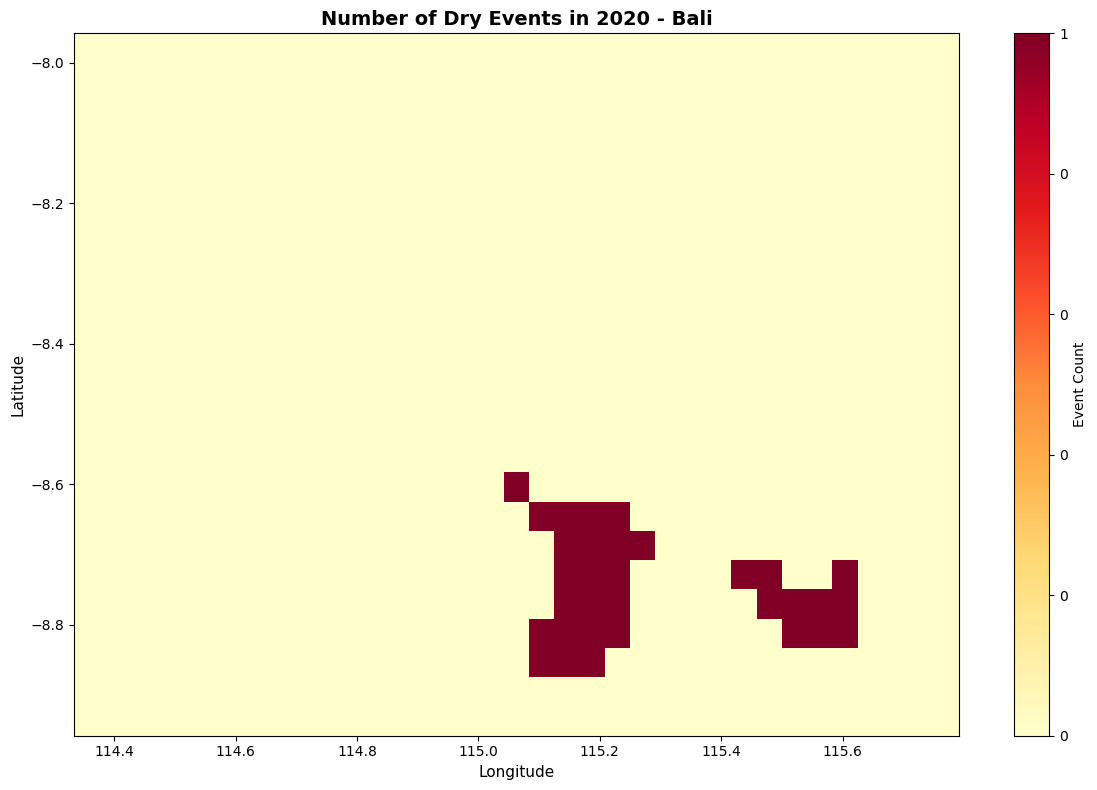

In [17]:
# Plot number of events
fig, ax = plt.subplots(figsize=(12, 8))

# Plot with integer formatting for discrete counts
im = stats_2020['num_events'].plot(ax=ax, cmap='YlOrRd', add_colorbar=True,
                                    cbar_kwargs={'label': 'Event Count', 
                                                'format': '%d'})  # Integer format

ax.set_title('Number of Dry Events in 2020 - Bali', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=11)
ax.set_ylabel('Latitude', fontsize=11)

plt.tight_layout()
plt.savefig('../output/plots/spatial/num_dry_events_2020_bali.png', dpi=300, bbox_inches='tight')
print("✓ Saved: num_dry_events_2020_bali.png")

plt.show()

### Map 2: Worst Severity in 2020

✓ Saved: worst_peak_2020_bali.png


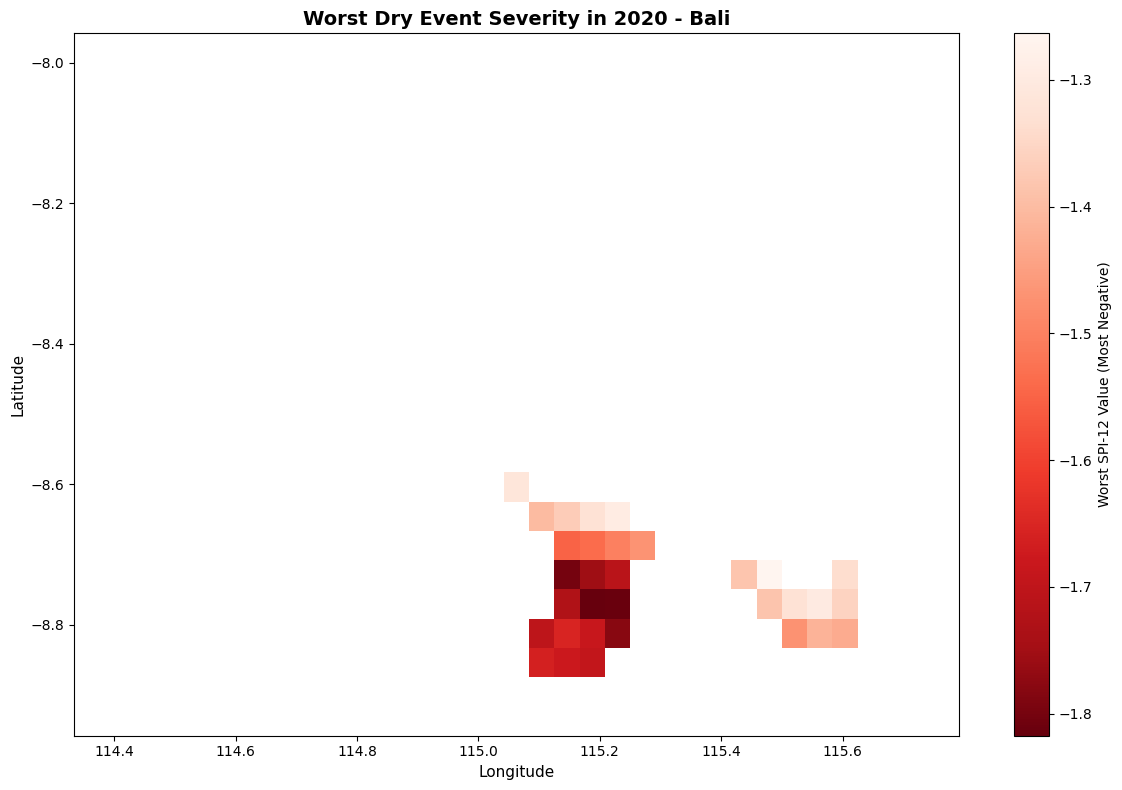

In [18]:
# Plot worst peak
fig, ax = plt.subplots(figsize=(12, 8))

# Use Reds colormap (darker red = more severe dry event = more negative SPI)
# Reverse the colormap so darker = worse
im = stats_2020['worst_peak'].plot(ax=ax, cmap='Reds_r', add_colorbar=True,
                                    cbar_kwargs={'label': 'Worst SPI-12 Value (Most Negative)'})

ax.set_title('Worst Dry Event Severity in 2020 - Bali', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=11)
ax.set_ylabel('Latitude', fontsize=11)

plt.tight_layout()
plt.savefig('../output/plots/spatial/worst_peak_2020_bali.png', dpi=300, bbox_inches='tight')
print("✓ Saved: worst_peak_2020_bali.png")

plt.show()

### Question 2: "Where was the worst dry event in the last 5 years?"

2026-01-25 12:13:28 | INFO     | runtheory | Calculating period statistics for 2020-2024
2026-01-25 12:13:28 | INFO     | runtheory | Processing location 0/840
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified

Calculating dry event statistics for 2020-2024...


2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with specified criteria
2026-01-25 12:13:28 | WARNING  | runtheory | No events found with

✓ 5-year statistics calculated
✓ Saved: worst_peak_2020-2024_bali.png


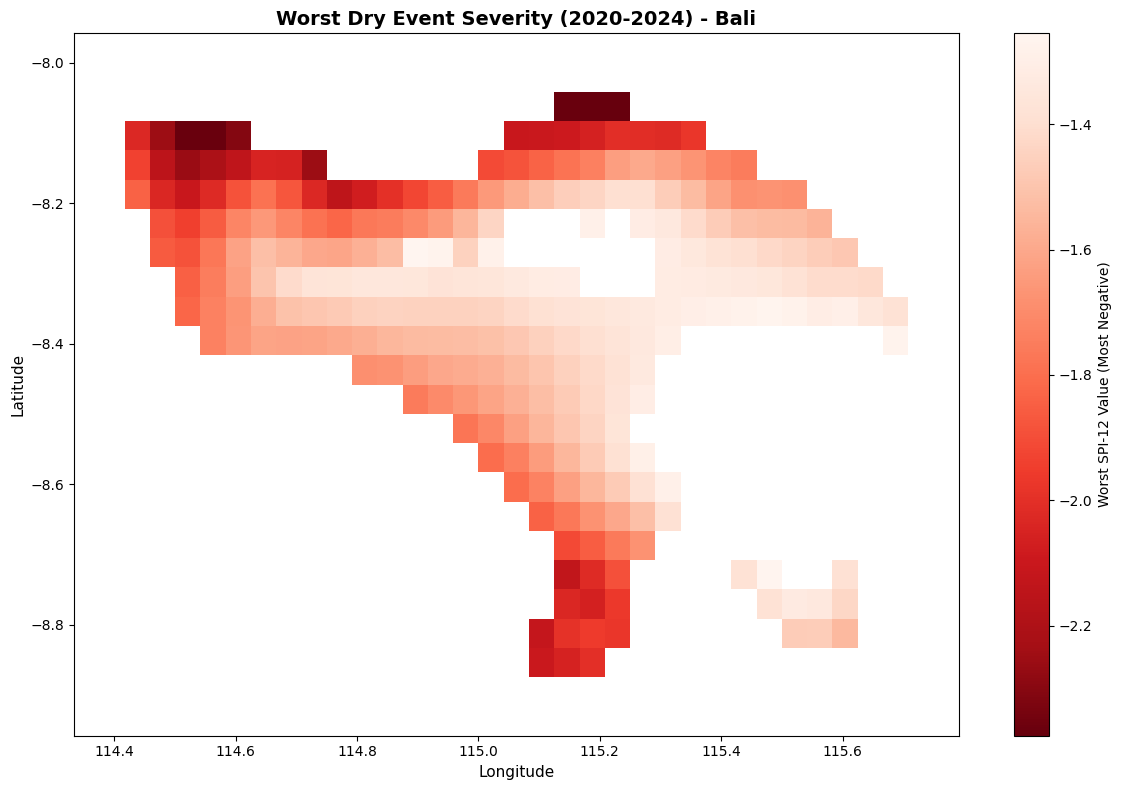

✓ Saved: dry_stats_2020-2024_bali.nc


In [19]:
# Calculate statistics for 2020-2024
print("Calculating dry event statistics for 2020-2024...")
stats_5yr = calculate_period_statistics(spi, threshold=threshold_dry,
                                        start_year=2020, end_year=2024,
                                        min_duration=min_duration)

print(f"✓ 5-year statistics calculated")

# Plot worst peak over 5 years
fig, ax = plt.subplots(figsize=(12, 8))

# Use Reds colormap (darker red = more severe)
im = stats_5yr['worst_peak'].plot(ax=ax, cmap='Reds_r', add_colorbar=True,
                                   cbar_kwargs={'label': 'Worst SPI-12 Value (Most Negative)'})

ax.set_title('Worst Dry Event Severity (2020-2024) - Bali', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=11)
ax.set_ylabel('Latitude', fontsize=11)

plt.tight_layout()
plt.savefig('../output/plots/spatial/worst_peak_2020-2024_bali.png', dpi=300, bbox_inches='tight')
print("✓ Saved: worst_peak_2020-2024_bali.png")

plt.show()

# Save
stats_5yr.to_netcdf('../output/netcdf/dry_stats_2020-2024_bali.nc')
print("✓ Saved: dry_stats_2020-2024_bali.nc")

### Multi-Variable Summary

✓ Saved: summary_2020-2024_bali.png


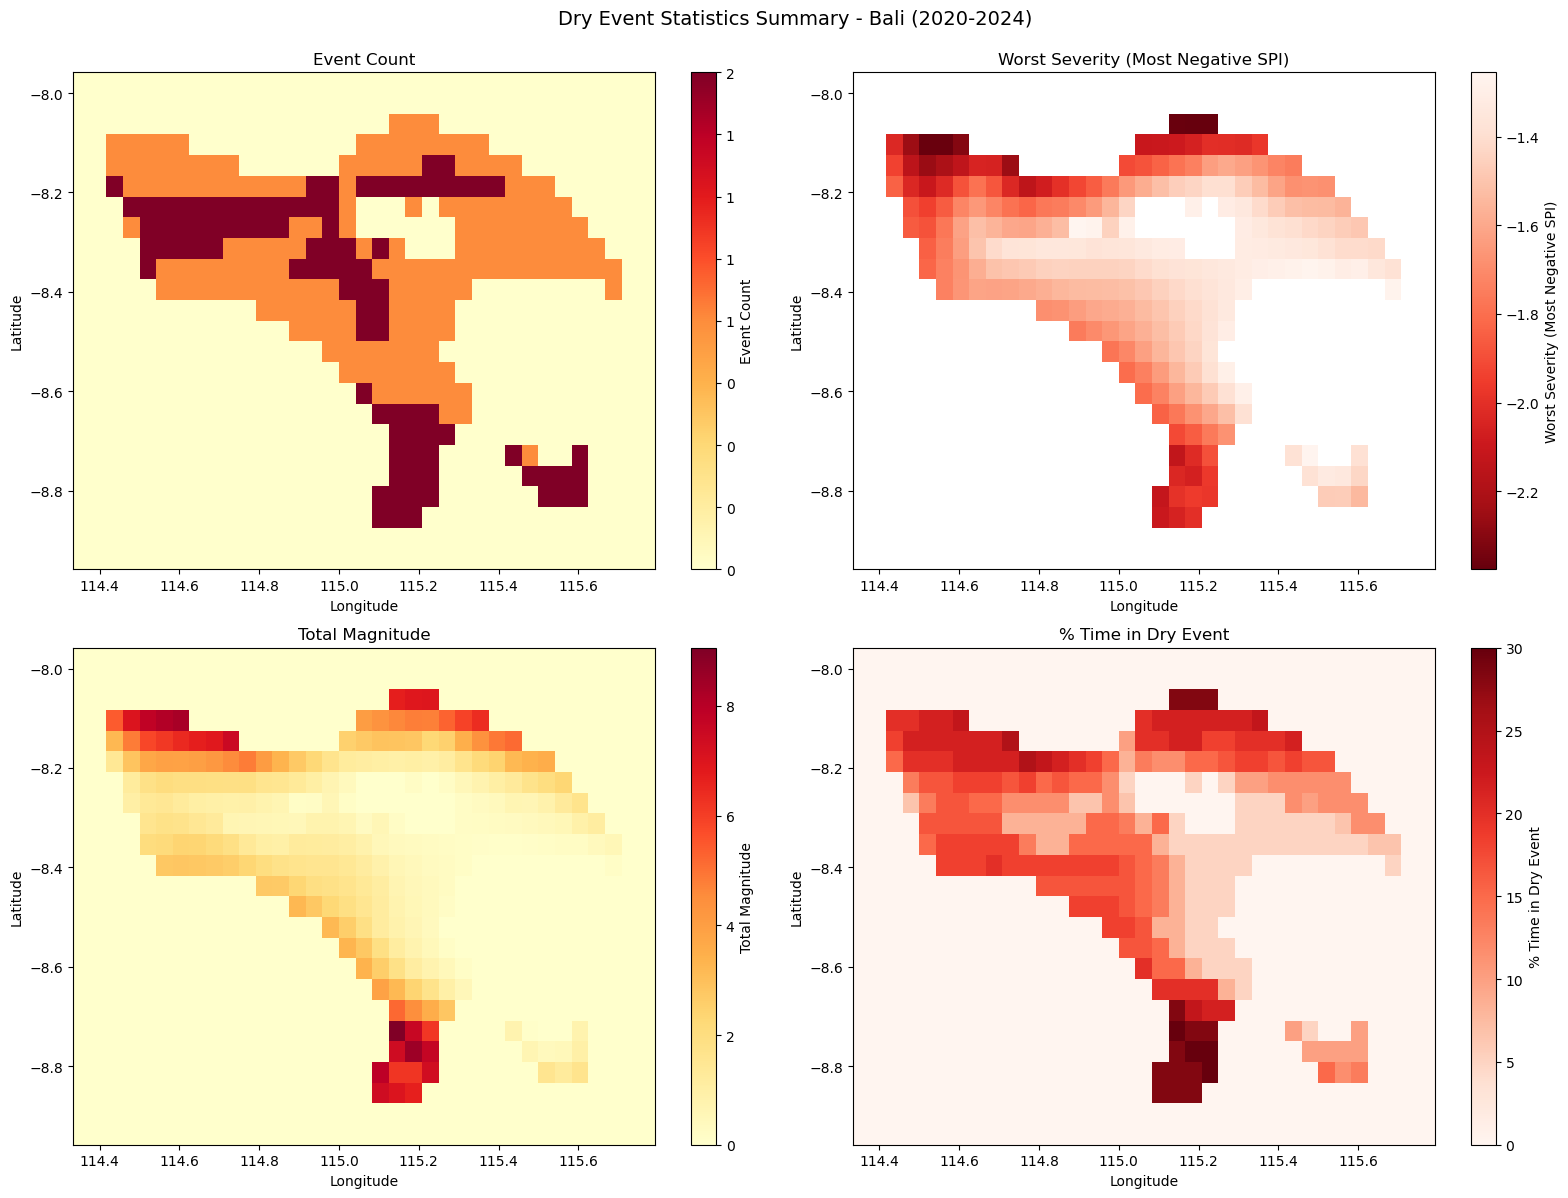

In [20]:
# Create 2x2 panel of key statistics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

variables = ['num_events', 'worst_peak', 'total_magnitude', 'pct_time_in_event']
titles = ['Event Count', 'Worst Severity (Most Negative SPI)', 'Total Magnitude', '% Time in Dry Event']
cmaps = ['YlOrRd', 'Reds_r', 'YlOrRd', 'Reds']  # Changed worst_peak to Reds_r
cbar_formats = ['%d', '%.2f', '%.1f', '%.0f%%']  # Integer for count, float for others

for ax, var, title, cmap, fmt in zip(axes.flat, variables, titles, cmaps, cbar_formats):
    # Determine colorbar format
    if var == 'num_events':
        cbar_kwargs = {'label': title, 'format': '%d'}
    elif var == 'pct_time_in_event':
        cbar_kwargs = {'label': title, 'format': '%.0f'}
    else:
        cbar_kwargs = {'label': title}
    
    stats_5yr[var].plot(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

plt.suptitle('Dry Event Statistics Summary - Bali (2020-2024)', fontsize=14, y=0.995)
plt.tight_layout()

plt.savefig('../output/plots/spatial/summary_2020-2024_bali.png', dpi=300, bbox_inches='tight')
print("✓ Saved: summary_2020-2024_bali.png")

plt.show()

## 8. Summary and Best Practices

### Three Modes Recap

| Mode | Function | Use Case | Output |
|------|----------|----------|--------|
| **Event-Based** | `identify_events()` | Historical analysis | DataFrame of events |
| **Time-Series** | `calculate_timeseries()` | Real-time monitoring | DataFrame by month |
| **Period Stats** | `calculate_period_statistics()` | Decision support | Gridded statistics |

### Bidirectional Application

All functions work for both extremes:
- **Dry events**: `threshold = -1.2`
- **Wet events**: `threshold = +1.2`

### Magnitude Types

- **Cumulative**: Total deficit/surplus, always increasing, use for event comparison
- **Instantaneous**: Current severity, NDVI-like pattern, use for monitoring evolution

See: [docs/user-guide/magnitude.md](../docs/user-guide/magnitude.md) for detailed explanation

### Best Practices

1. **Threshold**: Use ±1.0 or ±1.2 for operational monitoring
2. **Min Duration**: 3 months for SPI-12 (captures sustained events)
3. **Period Statistics**: Answer specific questions ("What happened in 2020?")
4. **Both Extremes**: Analyze both dry and wet to get complete picture
5. **Real Data**: Use actual climate data for meaningful insights

### Next Steps

- 📓 **Notebook 04**: Explore comprehensive visualization gallery
- 📖 **Documentation**: Read [docs/user-guide/runtheory.md](../docs/user-guide/runtheory.md) for methodology details
- 🔬 **Apply**: Use these techniques on your own SPI/SPEI datasets

In [21]:
# Final summary
print("\n" + "="*60)
print("NOTEBOOK COMPLETE")
print("="*60)
print(f"\n✓ Analyzed location: {lat_val:.2f}°, {lon_val:.2f}° (Central Bali)")
print(f"✓ Found {len(events_dry)} dry events and {len(events_wet)} wet events")
print(f"✓ Created time series with {len(ts_dry)} months")
print(f"✓ Calculated period statistics (2020, 2020-2024)")
print(f"\n✓ All outputs saved to ../output/")
print("\nSee output directories for:")
print("  - CSV files in output/csv/")
print("  - NetCDF files in output/netcdf/")
print("  - Plots in output/plots/single/ and output/plots/spatial/")


NOTEBOOK COMPLETE

✓ Analyzed location: -8.48°, 115.06° (Central Bali)
✓ Found 14 dry events and 8 wet events
✓ Created time series with 804 months
✓ Calculated period statistics (2020, 2020-2024)

✓ All outputs saved to ../output/

See output directories for:
  - CSV files in output/csv/
  - NetCDF files in output/netcdf/
  - Plots in output/plots/single/ and output/plots/spatial/
